# PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.
]
### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia.


### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.


In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_classif,mutual_info_classif
from scipy.stats import mannwhitneyu
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mutual_info_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from xgboost import XGBRegressor

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features:
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.

In [3]:
df=pd.read_csv("/content/credit_npo.csv")

In [4]:
df.rename(columns={"SeriousDlqin2yrs": "Target"}, inplace=True)

df.dropna( inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Target                                11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), 

In [6]:
columnas_numberOf_transform=["NumberOfDependents","NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfOpenCreditLinesAndLoans","NumberOfTime60-89DaysPastDueNotWorse"]
columnas_numericas=['age','RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome','NumberRealEstateLoansOrLines']
columnas_numericas_target=['age','RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome','NumberRealEstateLoansOrLines', "Target"]
columnas_categoricas=["NumberOfTime30-59DaysPastDueNotWorse","NumberOfOpenCreditLinesAndLoans","NumberOfTimes90DaysLate","NumberOfTime60-89DaysPastDueNotWorse","NumberOfDependents"]


In [10]:
len(df.columns)

11

In [7]:
for col in df[columnas_numberOf_transform]:
    print(col)
    print(df[col].unique())
    print(df[col].unique().shape)
    #print(df[col].value_counts())
    #print(df[col].value_counts().shape)

    print()

NumberOfDependents
[ 0.  2.  3.  1.  4.  5.  6.  8. 10.  7.]
(10,)

NumberOfTime30-59DaysPastDueNotWorse
[ 0  3  1  2  4 98  5  6  8  7]
(10,)

NumberOfTimes90DaysLate
[ 1  0  3  2 98  4  6  5  8  7 10  9 13]
(13,)

NumberOfOpenCreditLinesAndLoans
[12  9  2  4  3  5 11  8  7 13 10  1 14  6 16 15 19 18 17 22 20 23 29 24
 27  0 21 31 30 28 38 26 25 43 36 34 33 35 32 48 49 41 40]
(43,)

NumberOfTime60-89DaysPastDueNotWorse
[ 0  2  1  3 98  4  5 11]
(8,)



In [8]:
# dicionartio
bins_dict = {}

# voy a binnear las columnas con number of par5a q sean categoricas
intervalos=3

# Definir los limites de los intervalos para cada columna
for col in columnas_numberOf_transform:
    min_valor = df[col].min()
    max_valor = df[col].max()
    tamaño_intervalo= (max_valor - min_valor) // intervalos
    bins = [min_valor + tamaño_intervalo * i for i in range(intervalos + 1)]
    bins_dict[col] = bins
    print(bins)


[0.0, 3.0, 6.0, 9.0]
[0, 32, 64, 96]
[0, 32, 64, 96]
[0, 16, 32, 48]
[0, 32, 64, 96]


In [9]:
for col in df[columnas_numberOf_transform]:
    print(col)
    print(df[col].unique())
    print(df[col].unique().shape)

    print()


NumberOfDependents
[ 0.  2.  3.  1.  4.  5.  6.  8. 10.  7.]
(10,)

NumberOfTime30-59DaysPastDueNotWorse
[ 0  3  1  2  4 98  5  6  8  7]
(10,)

NumberOfTimes90DaysLate
[ 1  0  3  2 98  4  6  5  8  7 10  9 13]
(13,)

NumberOfOpenCreditLinesAndLoans
[12  9  2  4  3  5 11  8  7 13 10  1 14  6 16 15 19 18 17 22 20 23 29 24
 27  0 21 31 30 28 38 26 25 43 36 34 33 35 32 48 49 41 40]
(43,)

NumberOfTime60-89DaysPastDueNotWorse
[ 0  2  1  3 98  4  5 11]
(8,)



In [10]:
# ahora convertimos los valores unicos a letras para conbertirlas a categoricas
# diccionario para cambiar
dict_map= {0: 'AA', 1: 'BA', 2: 'CA', 3: 'DA', 4: 'EA', 5: 'FA', 6: 'GA', 7: 'HA', 8: 'IA', 9: 'JA', 10: 'KA', 11: 'LA', 12: 'MA', 13: 'NA', 14: 'OA', 15: 'PA',
       16: 'QA', 17: 'RA', 18: 'SA', 19: 'TA', 20: 'UA', 21: 'VA', 22: 'WA', 23: 'XA', 24: 'YA', 25: 'ZA', 26: 'AB', 27: 'BB', 28: 'CB', 29: 'DB', 30: 'EB',
       31: 'FB', 32: 'GB', 33: 'HB', 34: 'IB', 35: 'JB', 36: 'KB', 37: 'LB', 38: 'MB', 39: 'NB', 40: 'OB'}

for col in df[columnas_numberOf_transform]:
    df[col] = df[col].map(dict_map)


In [11]:
for col in df[columnas_numberOf_transform]:
    print(col)
    print(df[col].unique())
    print(df[col].unique().shape)

    print()

NumberOfDependents
['AA' 'CA' 'DA' 'BA' 'EA' 'FA' 'GA' 'IA' 'KA' 'HA']
(10,)

NumberOfTime30-59DaysPastDueNotWorse
['AA' 'DA' 'BA' 'CA' 'EA' nan 'FA' 'GA' 'IA' 'HA']
(10,)

NumberOfTimes90DaysLate
['BA' 'AA' 'DA' 'CA' nan 'EA' 'GA' 'FA' 'IA' 'HA' 'KA' 'JA' 'NA']
(13,)

NumberOfOpenCreditLinesAndLoans
['MA' 'JA' 'CA' 'EA' 'DA' 'FA' 'LA' 'IA' 'HA' 'NA' 'KA' 'BA' 'OA' 'GA'
 'QA' 'PA' 'TA' 'SA' 'RA' 'WA' 'UA' 'XA' 'DB' 'YA' 'BB' 'AA' 'VA' 'FB'
 'EB' 'CB' 'MB' 'AB' 'ZA' nan 'KB' 'IB' 'HB' 'JB' 'GB' 'OB']
(40,)

NumberOfTime60-89DaysPastDueNotWorse
['AA' 'CA' 'BA' 'DA' nan 'EA' 'FA' 'LA']
(8,)



In [35]:
df.dropna(inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11802 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Target                                11802 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11802 non-null  float64
 2   age                                   11802 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11802 non-null  object 
 4   DebtRatio                             11802 non-null  float64
 5   MonthlyIncome                         11802 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11802 non-null  object 
 7   NumberOfTimes90DaysLate               11802 non-null  object 
 8   NumberRealEstateLoansOrLines          11802 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11802 non-null  object 
 10  NumberOfDependents                    11802 non-null  object 
dtypes: float64(3), 

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Target,11802.0,0.069564,0.254422,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,11802.0,0.335119,0.364893,0.0,0.034915,0.178542,0.585850,6.0
age,11802.0,51.456194,14.514567,21.0,41.000000,51.000000,62.000000,101.0
DebtRatio,11802.0,0.500072,2.697619,0.0,0.143916,0.294881,0.477498,96.0
MonthlyIncome,11802.0,6868.176496,11861.865246,0.0,3500.000000,5416.500000,8302.500000,702500.0
NumberRealEstateLoansOrLines,11802.0,1.060244,1.140728,0.0,0.000000,1.000000,2.000000,19.0


In [38]:
df.head()

,Target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,AA,0.070709,5656.0,MA,BA,0,AA,AA
1,0,0.023413,74,AA,0.209197,4870.0,JA,AA,1,AA,AA
2,0,0.000000,43,AA,0.080784,5000.0,CA,AA,0,AA,CA
3,0,0.492754,44,AA,0.412735,7333.0,EA,AA,2,AA,DA
4,0,1.000000,63,AA,0.000000,8333.0,DA,AA,0,AA,BA


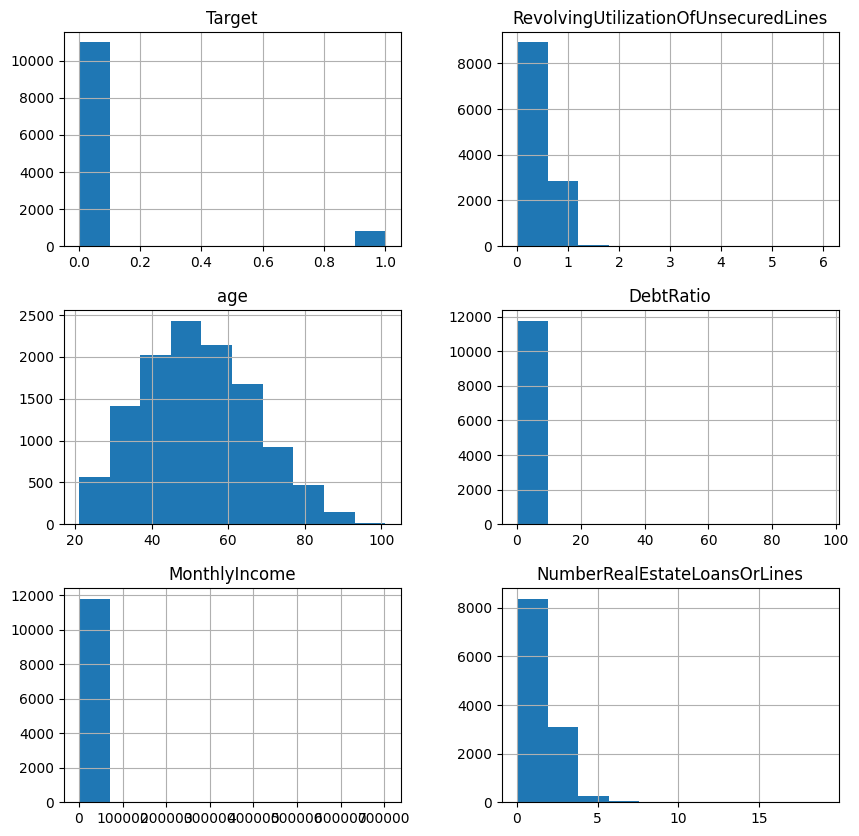

In [23]:
df.hist(figsize=(10,10))
plt.show()


In [22]:
def pinta_distribucion_categoricas(df, columnas_categoricas, relativa=False, mostrar_valores=False):
    num_columnas = len(columnas_categoricas)
    num_filas = (num_columnas // 2) + (num_columnas % 2)

    fig, axes = plt.subplots(num_filas, 2, figsize=(15, 5 * num_filas))
    axes = axes.flatten()

    for i, col in enumerate(columnas_categoricas):
        ax = axes[i]
        if relativa:
            total = df[col].value_counts().sum()
            serie = df[col].value_counts().apply(lambda x: x / total)
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis')
            ax.set_ylabel('Frecuencia Relativa')
        else:
            serie = df[col].value_counts()
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis')
            ax.set_ylabel('Frecuencia')

        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)

        if mostrar_valores:
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    for j in range(i + 1, num_filas * 2):
        axes[j].axis('off')

    plt.tight_layout()

    # Añadir leyenda
    if relativa:
        fig.legend(title='Legend Title', labels=['Frecuencia Relativa'], loc='upper right')

    plt.show()

<ipython-input-19-8fd95cbd39c5>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis')
<ipython-input-19-8fd95cbd39c5>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis')
<ipython-input-19-8fd95cbd39c5>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis')
<ipython-input-19-8fd95cbd39c5>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

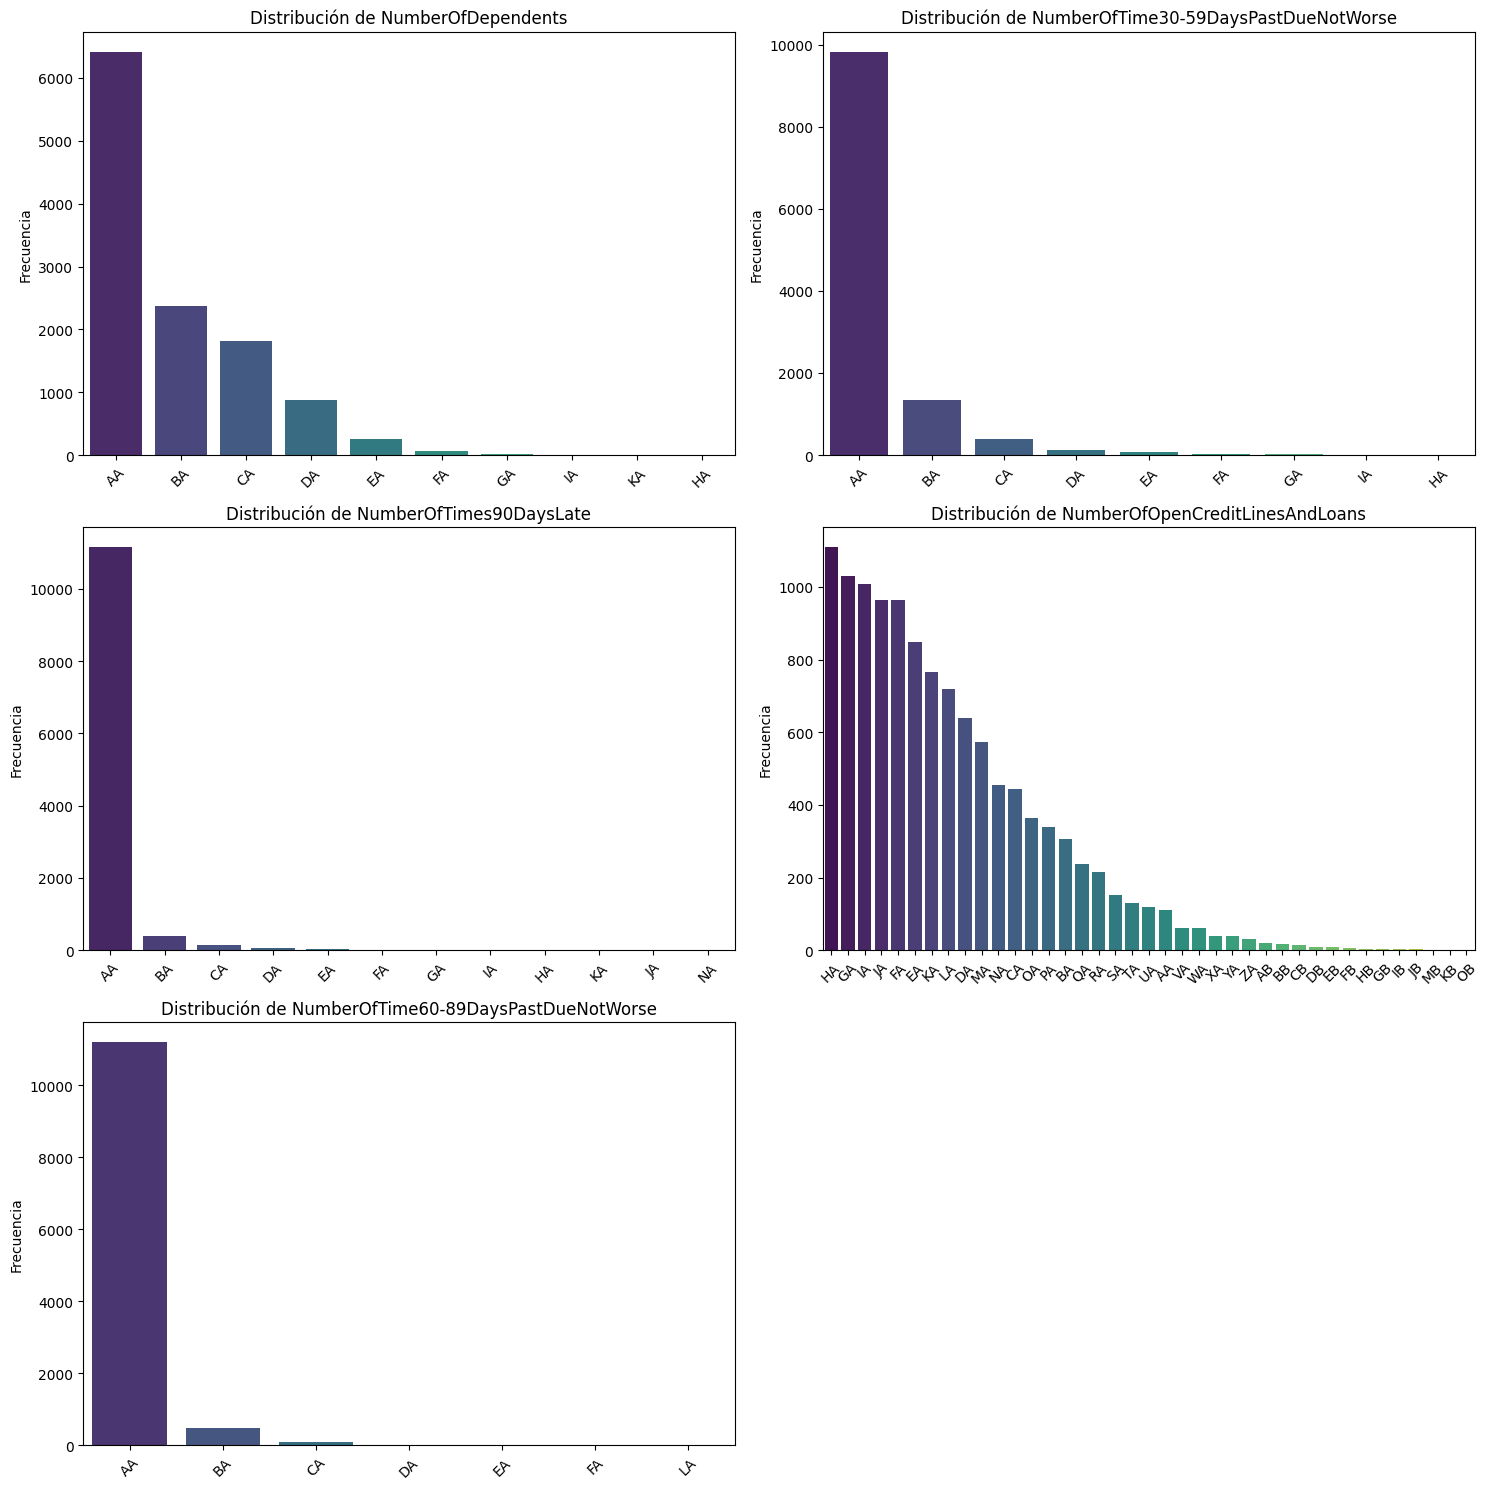

In [21]:
bt.pinta_distribucion_categoricas(df, columnas_categoricas=columnas_numberOf_transform);

In [24]:
# correlacion de pearson y spearman
correla_pearson=np.abs(df[columnas_numericas_target].corr())

correla_pearson.T

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberRealEstateLoansOrLines,Target
age,1.000000,0.258454,0.008830,0.053273,0.071614,0.106076
RevolvingUtilizationOfUnsecuredLines,0.258454,1.000000,0.010778,0.046920,0.092158,0.280350
DebtRatio,0.008830,0.010778,1.000000,0.036568,0.029228,0.001666
MonthlyIncome,0.053273,0.046920,0.036568,1.000000,0.162305,0.022199
NumberRealEstateLoansOrLines,0.071614,0.092158,0.029228,0.162305,1.000000,0.001321
Target,0.106076,0.280350,0.001666,0.022199,0.001321,1.000000


In [31]:
correla_spearman = np.abs(df[columnas_numericas_target].corr(method='spearman'))
correla_spearman.T

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberRealEstateLoansOrLines,Target
age,1.000000,0.258269,0.056271,0.128051,0.103872,0.107965
RevolvingUtilizationOfUnsecuredLines,0.258269,1.000000,0.192542,0.079860,0.056801,0.244501
DebtRatio,0.056271,0.192542,1.000000,0.089052,0.602734,0.047127
MonthlyIncome,0.128051,0.079860,0.089052,1.000000,0.401609,0.060418
NumberRealEstateLoansOrLines,0.103872,0.056801,0.602734,0.401609,1.000000,0.024649
Target,0.107965,0.244501,0.047127,0.060418,0.024649,1.000000



NUMERICAS.- age tiene una correlacion perfecta y elk resto inclusive la target tiene valores cercanos al 0, por lo que no hay mucho correlacion

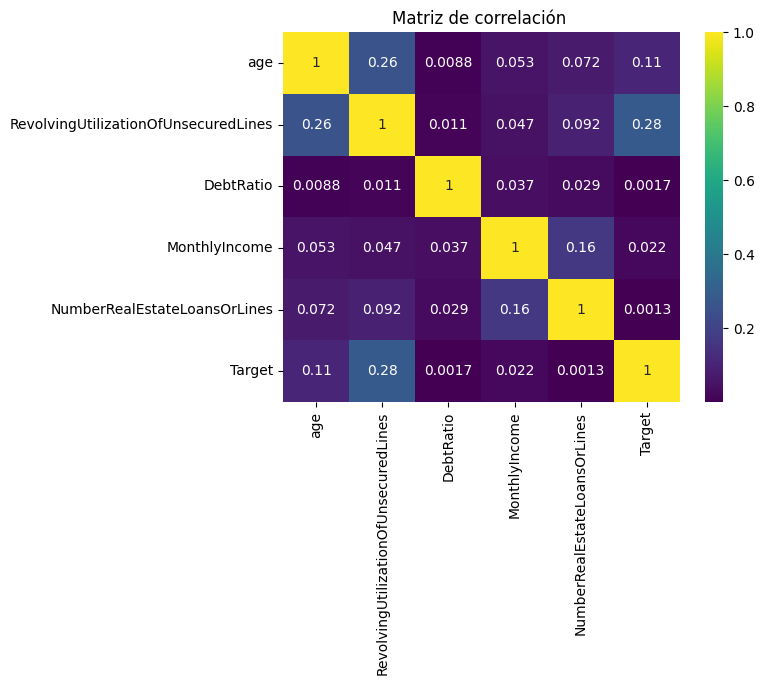

In [32]:
sns.heatmap(correla_pearson, annot=True, cmap='viridis');
plt.title("Matriz de correlación ")
plt.show()

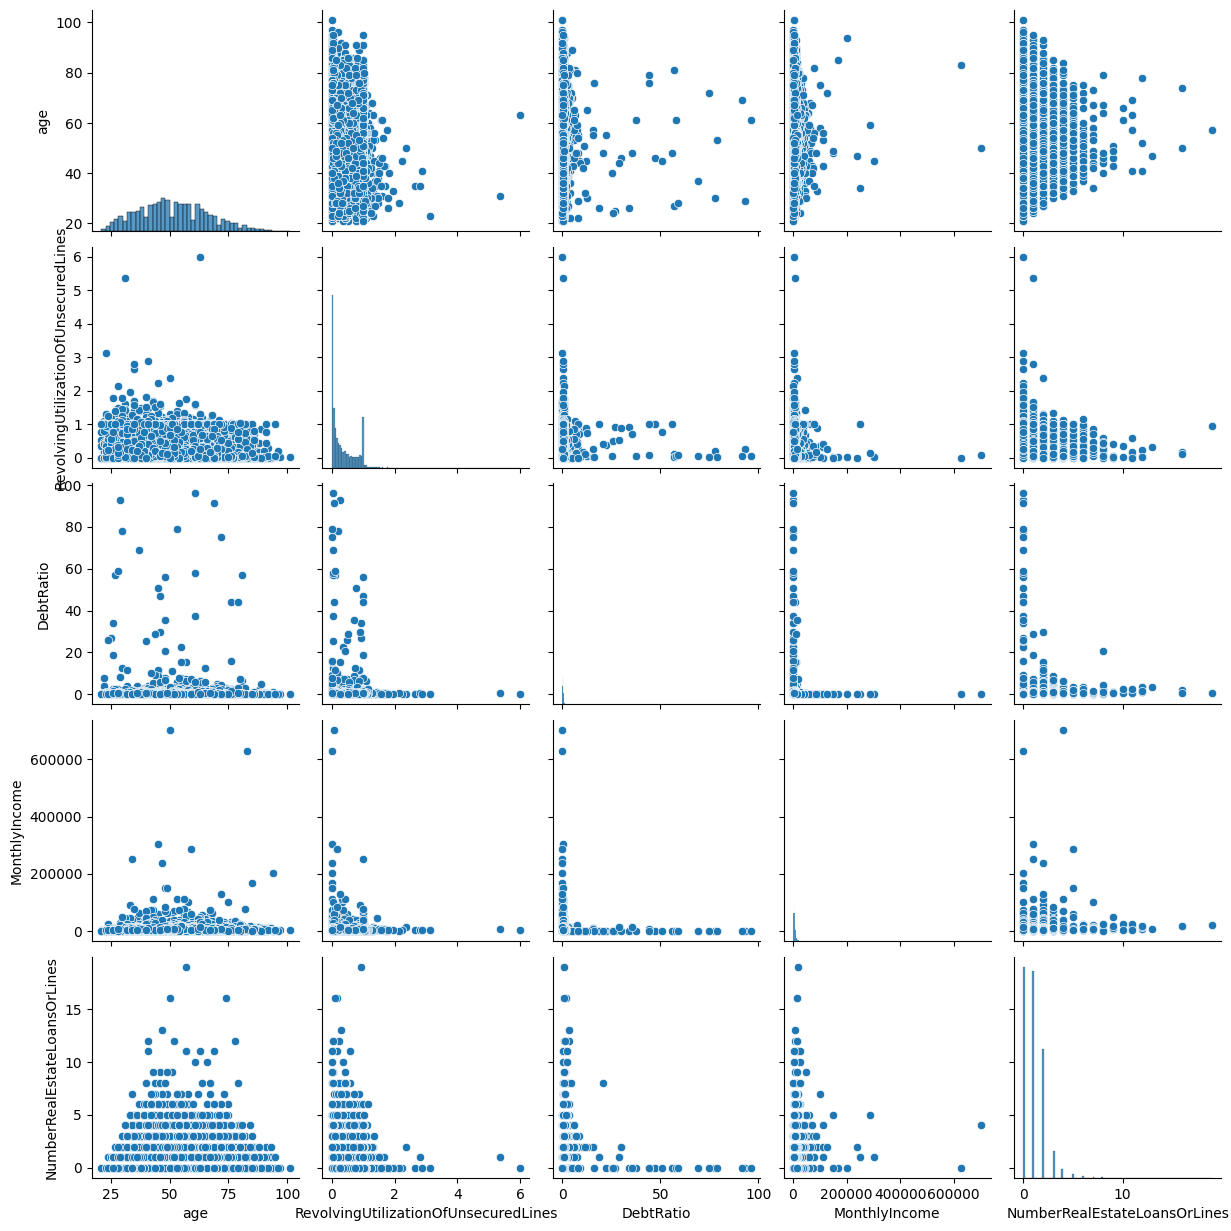

In [51]:
sns.pairplot(df[columnas_numericas])

In [26]:
# umbral de covarianza
#matriz de coovarianza por cada valor de cada columna
coov= df[columnas_numericas_target].cov()
coov

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberRealEstateLoansOrLines,Target
age,210.722106,-1.370189,-0.345597,9.168540e+03,1.185850,-0.393533
RevolvingUtilizationOfUnsecuredLines,-1.370189,0.133378,0.010612,-2.031588e+02,-0.038393,0.026167
DebtRatio,-0.345597,0.010612,7.268776,-1.168880e+03,0.089889,-0.001148
MonthlyIncome,9168.540282,-203.158804,-1168.880498,1.405625e+08,2195.052217,-67.262954
NumberRealEstateLoansOrLines,1.185850,-0.038393,0.089889,2.195052e+03,1.301232,0.000385
Target,-0.393533,0.026167,-0.001148,-6.726295e+01,0.000385,0.065315


<Axes: >

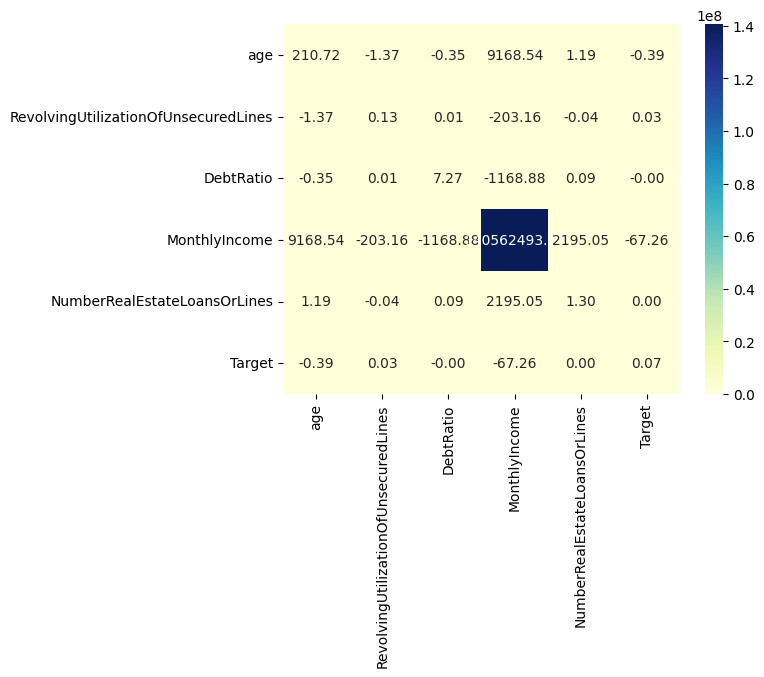

In [27]:
sns.heatmap(coov, annot=True, fmt=".2f", cmap="YlGnBu")

In [28]:
# media de la coov entre todas laas coovarianzas, para determinar la tenedencia general  de las relaciones lineales, indicando la direccion ( + (variables similares ) o ( con amportamientos opuestros-)
#o sino exuste ( cercana a 0)
media_cov = (coov.mean())
media_cov

age                                     1.563056e+03
RevolvingUtilizationOfUnsecuredLines   -3.406620e+01
DebtRatio                              -1.936430e+02
MonthlyIncome                           2.342874e+07
NumberRealEstateLoansOrLines            3.662652e+02
Target                                 -1.126096e+01
dtype: float64

In [29]:
# std coovarianza son los valores que se mueven alrededor de la media, siendo una medida de dispersion
desviacion_estandar_cov = coov.std()
desviacion_estandar_cov

age                                     3.726866e+03
RevolvingUtilizationOfUnsecuredLines    8.284004e+01
DebtRatio                               4.777759e+02
MonthlyIncome                           5.738359e+07
NumberRealEstateLoansOrLines            8.959192e+02
Target                                  2.743578e+01
dtype: float64

In [30]:
# umbral estandar para comprobar la significacion en el porcetaje que toamemos como valor critico, es decir si supera el umpral tiene esta significacion , en caso contrario no se puede concluir
z = 1.96 # Nivel de confianza del 95%
umbral_estandar = media_cov + (z * desviacion_estandar_cov)
umbral_estandar

age                                     8.867715e+03
RevolvingUtilizationOfUnsecuredLines    1.283003e+02
DebtRatio                               7.427977e+02
MonthlyIncome                           1.359006e+08
NumberRealEstateLoansOrLines            2.122267e+03
Target                                  4.251316e+01
dtype: float64

 Podemos concluir con un 95% de confianza existe un covarianza significativa entre : Target y DebtRatio, Target y age.
La media de la coovarianza muestra una tenedencia de comportamiento opuestos algunas de las variables en un 50%, concretamente, en la Target, Debratio y otra mas,  y age y otras 2 mas, tendencia positiva, con compartamientos similares.
La variable target presenta ciertos valores de dispersion, aqunue inferiroes a Debratio y age.

In [33]:
#2.- para calcular la seleccion de mejores numerica empleamos el metodo f_classif, que nos dara este resultado usando en la metrica una categorica
#features_numumericas
X_train = df[columnas_numericas_target]
y_train = df["NumberOfDependents"]# categorica
selector = SelectKBest(f_classif, k=5)
X_kbest = selector.fit_transform(X_train, y_train)
X_train_kbest = pd.DataFrame(X_kbest, columns = selector.get_feature_names_out())
X_train_kbest

# orden de pvalues mas alto a mas bajo, siendo las que mas aportan a la clasificacion, indicando el p_values bajo q es poco probable que las diferencia en la distribucion de las caracteristicas se deba al azar, mas confianza
# ['DebtRatio', 'Target', 'RevolvingUtilizationOfUnsecuredLines', 'MonthlyIncome', 'NumberRealEstateLoansOrLines', "age"]

,age,RevolvingUtilizationOfUnsecuredLines,MonthlyIncome,NumberRealEstateLoansOrLines,Target
0,37.0,0.081892,5656.0,0.0,0.0
1,74.0,0.023413,4870.0,1.0,0.0
2,43.0,0.000000,5000.0,0.0,0.0
3,44.0,0.492754,7333.0,2.0,0.0
4,63.0,1.000000,8333.0,0.0,0.0
...,...,...,...,...,...
11811,59.0,0.197116,5140.0,1.0,0.0
11812,62.0,0.036726,5833.0,1.0,0.0
11813,49.0,0.120313,6333.0,2.0,0.0
11814,63.0,0.252566,14000.0,0.0,0.0


MUTUAL INFORMATION

In [39]:
# seleccion de categoricas
# Mutual Information para las 3 categoricas

target="Target"
for col in columnas_categoricas:
    print(f"MUTUAL INFORMATION \n ({col};{target}:", mutual_info_score(df[col], df["Target"]))

MUTUAL INFORMATION 
 (NumberOfTime30-59DaysPastDueNotWorse;Target: 0.02292913014926084
MUTUAL INFORMATION 
 (NumberOfOpenCreditLinesAndLoans;Target: 0.005362354220820276
MUTUAL INFORMATION 
 (NumberOfTimes90DaysLate;Target: 0.034813308125145985
MUTUAL INFORMATION 
 (NumberOfTime60-89DaysPastDueNotWorse;Target: 0.018830676535302897
MUTUAL INFORMATION 
 (NumberOfDependents;Target: 0.001341258050742701


SELECT FROM MODEL

In [43]:
np.random.seed(42)
# modelos
dt=DecisionTreeRegressor()
lr=LinearRegression()

In [45]:
dt.fit(df[columnas_numericas], df[target])

DecisionTreeRegressor()

In [46]:
lr.fit(df[columnas_numericas], df[target])

LinearRegression()

In [47]:
features_importantes= dt.feature_importances_
features_importantes= pd.DataFrame({'feature': columnas_numericas, 'importancia': features_importantes})
features_importantes.sort_values('importancia', ascending=False, inplace=True)
features_importantes

,feature,importancia
1,RevolvingUtilizationOfUnsecuredLines,0.327829
2,DebtRatio,0.254753
3,MonthlyIncome,0.227083
0,age,0.134133
4,NumberRealEstateLoansOrLines,0.056202


metodo intrinseco select from model

In [52]:
# ahora usasremos selectfrommodel como metodo intrinseco para scarar las mejores features o mas influyentes
# seleccionamos un modelo simple: linear regression y decisiontreregressor
np.random.seed(42)
selector_sfm_dt=DecisionTreeRegressor()
selector_sfm_lr=LinearRegression()

In [53]:
selector_sfm_dt.fit(df[columnas_numericas], df[target])

DecisionTreeRegressor()

In [54]:
selector_sfm_lr.fit(df[columnas_numericas], df[target])

LinearRegression()

In [50]:
lr.fit(df[columnas_numericas], df[target])

LinearRegression()

In [55]:
# resultado decision tree
selector_sfm_dt.feature_importances_


array([0.14100966, 0.32078643, 0.26332715, 0.22413238, 0.05074437])

In [57]:
selector_sfm_dt.feature_importances_.mean()

0.2

In [191]:
# mejores features
best_features=selector_sfm_dt.feature_importances_[selector_sfm_dt.feature_importances_ > selector_sfm_dt.feature_importances_.mean()]

In [192]:
best_features

array([0.35872668, 0.34041407])

In [193]:
#resultado linear regresion
selector_sfm_lr.coef_

array([ 1.91116347e-01, -1.55715848e-04, -2.31045067e-07])

RFE

In [60]:
# vamos a selecionar features con el metodo RFE o eliminacion recursica de varibales, el cual funciona como un selefrommodel reiterativo
# saco el x e y train
X_train_lr = df[columnas_numericas]
y_train_lr = df[target]

In [106]:
np.random.seed(42)
estimator_rfe =LinearRegression()
# Crear un selector de características RFE
selector = RFE(estimator_rfe, n_features_to_select=3, step=1)

In [62]:
# Aplicar el selector a tus datos de entrenamiento
selector = selector.fit(X_train_lr, y_train_lr)

In [63]:
selector.ranking_

array([1, 1, 2, 3, 1])

In [64]:
features_RFE= pd.DataFrame(selector.ranking_, columns= ["ranking"], index = columnas_numericas).sort_values("ranking")
features_RFE

,ranking
age,1
RevolvingUtilizationOfUnsecuredLines,1
NumberRealEstateLoansOrLines,1
DebtRatio,2
MonthlyIncome,3


In [65]:
#hacemos el dataframe final-
RFE= pd.DataFrame(selector.transform(X_train_lr), columns=selector.get_feature_names_out())
RFE

,age,RevolvingUtilizationOfUnsecuredLines,NumberRealEstateLoansOrLines
0,37.0,0.081892,0.0
1,74.0,0.023413,1.0
2,43.0,0.000000,0.0
3,44.0,0.492754,2.0
4,63.0,1.000000,0.0
...,...,...,...
11797,59.0,0.197116,1.0
11798,62.0,0.036726,1.0
11799,49.0,0.120313,2.0
11800,63.0,0.252566,0.0


SFS

In [66]:
X_train_xb= X_train_lr.copy()
y_train_xb = y_train_lr.copy()

In [67]:
# ahora vamos seleccionar con el SFS o seleccion secuancial de variables, con el empezamos al reves q el rfe, partimos de una feature hasta llegar a la ultima y nos quedamos con las que esten en eel umbral de tolerancia,
# aplicando un modelo y lo mas importante es que no es necesario que el modelo a usar tenga feature_importance o coef_

xb_SFS = XGBRegressor(random_state = 42)

In [68]:
select_sfs = SequentialFeatureSelector(xb_SFS,n_features_to_select = 3,cv = 5,  scoring = "neg_root_mean_squared_error")

select_sfs = select_sfs.fit(X_train_xb, y_train_xb)

In [69]:
select_sfs.get_feature_names_out()

array(['age', 'RevolvingUtilizationOfUnsecuredLines',
       'NumberRealEstateLoansOrLines'], dtype=object)

HARDVOTING

In [127]:
df.head(2)

,Target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,AA,0.070709,5656.0,MA,BA,0,AA,AA
1,0,0.023413,74,AA,0.209197,4870.0,JA,AA,1,AA,AA


In [128]:
X=df[columnas_numericas]
y=df["Target"]

In [139]:
# División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [130]:
# Entrenamiento de los modelos sin selección de características
selector_sfm_dtdt = DecisionTreeRegressor().fit(X_train, y_train)
selector_sfm_lr =  LinearRegression().fit(X_train, y_train)
estimator_rfe = LinearRegression().fit(X_train, y_train)
select_sfs = XGBRegressor().fit(X_train, y_train)


In [131]:
# Diccionario para almacenar los modelos
modelos = {
    "Decision Tree": selector_sfm_dt,
    "Linear Regression_sfm": selector_sfm_lr,
    "Linear Regression": estimator_rfe,
    "XGBoost": select_sfs,
}

In [144]:
# Entrenamiento de los modelos con SelectFromModel
selector_voting_sfm1 = SelectFromModel(estimator=selector_sfm_dt)
X_train_vot = selector_voting_sfm1.fit_transform(X_train, y_train)
for modelo in modelos.keys():
    modelos["Decision Tree"] = modelos[modelo].fit(X_train_vot, y_train)

In [145]:
# Entrenamiento de los modelos con SelectFromModel
selector_voting_sfm2 = SelectFromModel(estimator=selector_sfm_lr)
X_train_vot = selector_voting_sfm2.fit_transform(X_train, y_train)
for modelo in modelos.keys():
    modelos["Linear Regression_sfm"] = modelos[modelo].fit(X_train_vot, y_train)

In [172]:
# Entrenamiento de los modelos con RFE
selector_rfe = RFE(estimator=selector_sfm_dt, n_features_to_select=5)
X_train_vot = selector_rfe.fit_transform(X_train, y_train)
for modelo in modelos.keys():
    modelos["Linear Regression_rfe"] = modelos[modelo].fit(X_train_vot, y_train)

In [147]:
# Entrenamiento de los modelos con SFS
selector_voting_sfs = SequentialFeatureSelector(estimator=select_sfs, n_features_to_select="auto")
X_train_vot = selector_voting_sfs.fit_transform(X_train, y_train)
for modelo in modelos.keys():
    modelos["XGBoost"] = modelos[modelo].fit(X_train_vot, y_train)

In [168]:
# creo una lista de los modelos
lista_modelos = list(modelos.items())
# Crear el VotingRegressor con la lista de modelos
voting = VotingRegressor(estimators=lista_modelos)

In [174]:
voting.fit(X_train, y_train)
y_pred_voting = voting.predict(X_test)

# Obtener predicciones individuales de cada modelo
y_pred_dt = voting.estimators_[0].predict(X_test)
y_pred_lr = voting.estimators_[1].predict(X_test)
y_pred_xgb = voting.estimators_[2].predict(X_test)
y_pred_lr = voting.estimators_[3].predict(X_test)
# Evaluación del ensemble dt
mse=mean_squared_error(y_test,y_pred_dt)
rmse= np.sqrt(mse)
print(f"dt_sfm: {mse}")
print(f"dt_sfm: {rmse}")
print()
# Evaluación del ensemble dt
mse=mean_squared_error(y_test,y_pred_lr)
rmse= np.sqrt(mse)
print(f"lr_sfm: {mse}")
print(f"lr_sfm: {rmse}")
print()
# Evaluación del ensemble dt
mse=mean_squared_error(y_test,y_pred_lr)
rmse= np.sqrt(mse)
print(f"rfe: {mse}")
print(f"rfe: {rmse}")
print()
# Evaluación del ensemble dt
mse=mean_squared_error(y_test,y_pred_xgb)
rmse= np.sqrt(mse)
print(f"SNS: {mse}")
print(f"SNS: {rmse}")
print()
# Evaluación del ensemble
mse=mean_squared_error(y_test,y_pred_voting)
rmse= np.sqrt(mse)
print(f"Voting: {mse}")
print(f"Voting: {rmse}")

dt_sfm: 0.06673891704601863
dt_sfm: 0.25833876411800577

lr_sfm: 0.06673891704601863
lr_sfm: 0.25833876411800577

rfe: 0.06673891704601863
rfe: 0.25833876411800577

SNS: 0.05839644687439426
SNS: 0.24165356789088438

Voting: 0.0628557441935822
Voting: 0.2507104788268376


### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.



